In [1]:
'''Trains a denoising autoencoder on MNIST dataset.

Denoising is one of the classic applications of autoencoders.
The denoising process removes unwanted noise that corrupted the
true signal.

Noise + Data ---> Denoising Autoencoder ---> Data

Given a training dataset of corrupted data as input and
true signal as output, a denoising autoencoder can recover the
hidden structure to generate clean data.

This example has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### data pre-processing

In [2]:
np.random.seed(1337)

# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

# adding noise may exceed normalized pixel values>1.0 or <0.0
# clip pixel values >1.0 to 1.0 and <0.0 to 0.0
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

## Implement autoencoder

In [3]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [4]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [5]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_________________________________________________________________


In [6]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 17s 281us/step - loss: 0.0349 - val_loss: 0.0199
Epoch 2/10
60000/60000 [==============================] - 15s 247us/step - loss: 0.0191 - val_loss: 0.0179
Epoch 3/10
60000/60000 [==============================] - 15s 245us/step - loss: 0.0176 - val_loss: 0.0169
Epoch 4/10
60000/60000 [==============================] - 15s 248us/step - loss: 0.0167 - val_loss: 0.0166
Epoch 5/10
60000/60000 [==============================] - 15s 244us/step - loss: 0.0162 - val_loss: 0.0162
Epoch 6/10
60000/60000 [==============================] - 15s 244us/step - loss: 0.0159 - val_loss: 0.0161
Epoch 7/10
60000/60000 [==============================] - 15s 243us/step - loss: 0.0156 - val_loss: 0.0159
Epoch 8/10
60000/60000 [==============================] - 15s 244us/step - loss: 0.0153 - val_loss: 0.0158
Epoch 9/10
60000/60000 [==============================] - 15s 243us/step - loss: 0.0151 - val_

In [8]:
# model save
save_model = 1
if save_model:
    from keras.models import load_model
    autoencoder.save('saved_model/denoising-autoencoder_latent_size16.h5')

In [9]:
# predict the autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

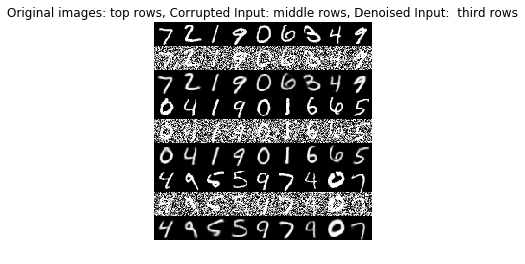

In [10]:
# 3 sets of images with 9 MNIST digits
# 1st rows - original images
# 2nd rows - images corrupted by noise
# 3rd rows - denoised images
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

### test more

In [ ]:
# model load
if 0 :
    autoencoder = load_model('saved_model/denoising-autoencoder_latent_size16.h5')

In [19]:
# ...
sample_start_position = 20
n_test_samples = 10
latent_vectors = encoder.predict(x_test[sample_start_position:sample_start_position + n_test_samples])

In [20]:
latent_vectors.shape

(10, 16)

In [21]:
latent_vectors[0]

array([ 0.6489818 , -0.58342856, -1.1032429 , -0.69909203,  0.72335255,
        0.01617292,  1.2771858 ,  0.5937833 ,  0.09238756,  0.5280661 ,
        0.1203486 ,  1.6772978 ,  0.28036755, -0.565603  , -0.04915571,
       -1.4875488 ], dtype=float32)

[ 0.6489818  -0.58342856 -1.1032429  -0.69909203  0.72335255  0.01617292
  1.2771858   0.5937833   0.09238756  0.5280661   0.1203486   1.6772978
  0.28036755 -0.565603   -0.04915571 -1.4875488 ]
(10, 28, 28, 1)


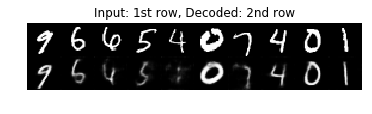

In [22]:
### ########################################
#### Manipulate latent vector ##########

# latent_vectors[0][0] = -11

########################################
print(latent_vectors[0])


decoded_imgs = decoder.predict(latent_vectors)
print(decoded_imgs.shape)

# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[sample_start_position:sample_start_position + n_test_samples], decoded_imgs[:n_test_samples]])
imgs = imgs.reshape((2, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st row, Decoded: 2nd row')
plt.imshow(imgs, interpolation='none', cmap='gray')
# plt.savefig('input_and_decoded.png')
plt.show()